In [1]:


try:
    isMaster
except NameError:
    isMaster = False
    
    from app.dotenv import base_dir, data_dir
    from app.object_detection.yolo import loadYOLOv8Model
    # loadModelYOLO 
    from app.load_data import *
    from app.change_detect.opticalflow import *
    from app.object_detection.cropROI import *
    from app.object_detection.yolo import inferenceYOLOv8Model,plotClassifcation
    

    # load yolo model
    # model_version=5
    # model = loadYOLOv8Model(data_dir,model_version=model_version)
    model = loadYOLOv8Model(data_dir)
    
    # create images if they fon't exist
    save_path = f'{data_dir}\images'
    if not (os.path.exists(save_path) and len(os.listdir(save_path)) > 0):
        saveVideoFrames(video_path = f"{data_dir}/vtest.avi",save_path = save_path)
    
    image_num = 3
print('isMaster:', isMaster)

# from app.utils import *

# from app.model.model import  Model
# import os

# print('dotenv params:', {os.getenv('PARAM1')})
# print('base_dir:', base_dir)
# print('data_dir:', data_dir)

# model = Model()
# print('model:', model)






Model YOLO V8 weights loaded successfully
isMaster: False


#### Detecting the change

Background subtraction base model


In [2]:
# pass

load image and Background base model

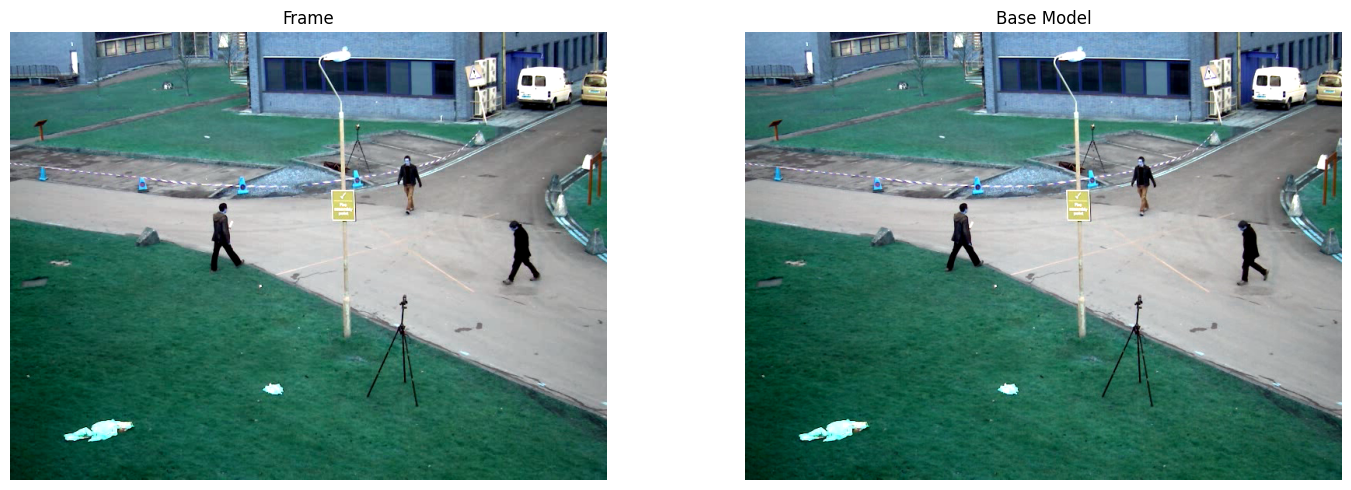

In [3]:

next_rgb = loadFrame(save_path =f"{save_path}/{image_num}.png")
# consecutive frame used as baseModel 
baseModel_rgb = loadFrame(save_path = f"{save_path}/{image_num-1}.png")

if not isMaster:
    plotFrames(baseModel_rgb, next_rgb)


#### detect the change

1. optical flow

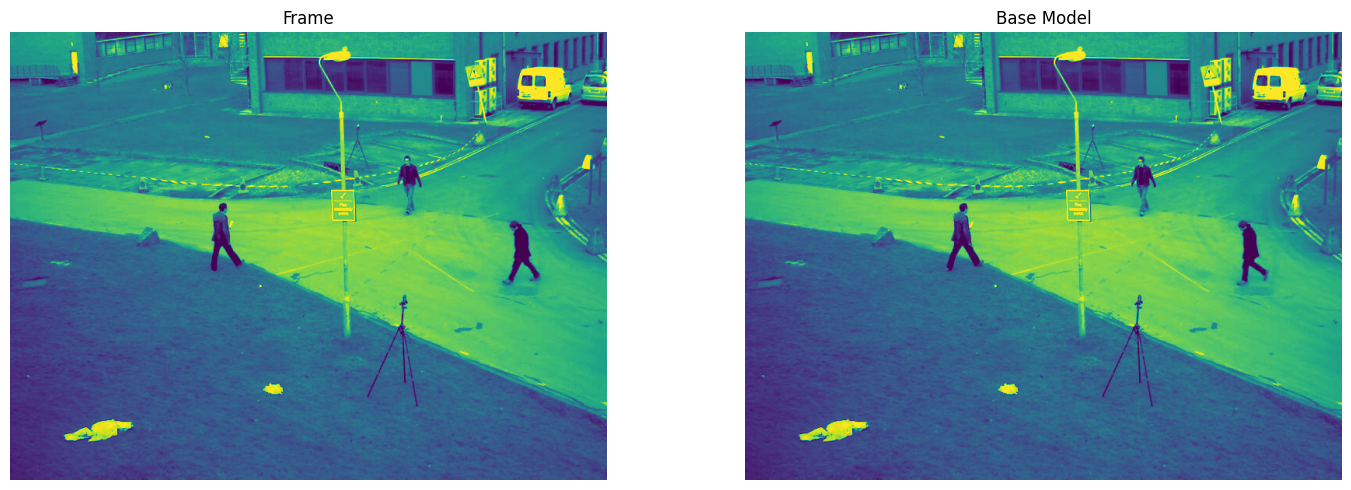

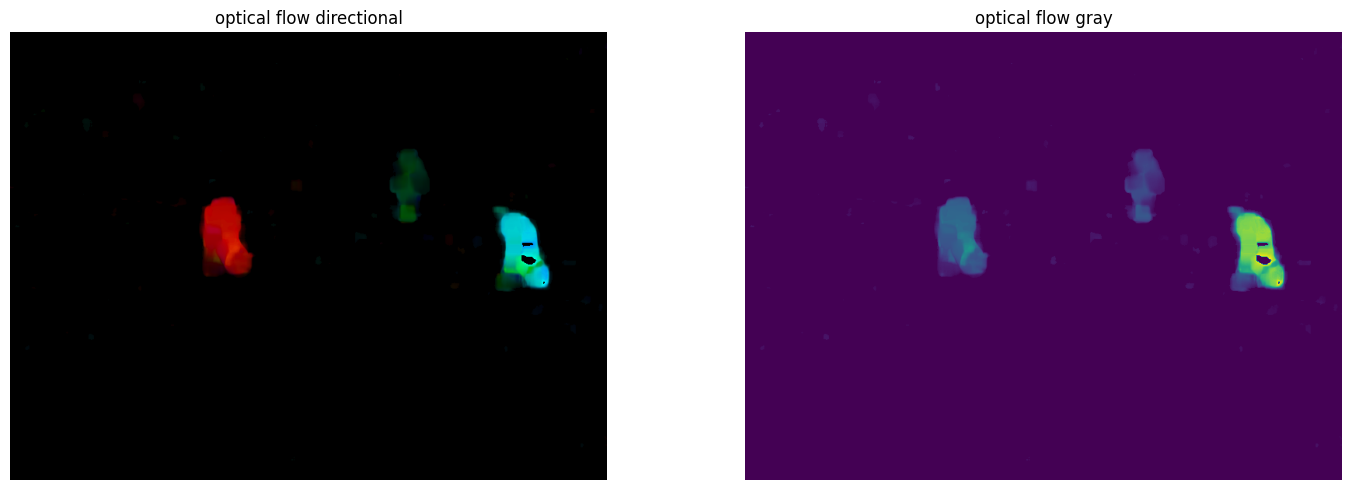

In [4]:


next_gray = grayFrame(next_rgb)
baseModel_gray = grayFrame(baseModel_rgb)
if not isMaster:
    plotFrames(baseModel_gray, next_gray)

# consecutive frame used as baseModel 




OpticalFlow_rgb,OpticalFlow_gray = opticalFlow(baseModel_gray, next_gray) 
if not isMaster:
    plotFrames(OpticalFlow_rgb,OpticalFlow_gray,'optical flow directional','optical flow gray') 
        
    
    





#### Object detection - ROI
1. find ROIs
2. crop image
3. save crop to file

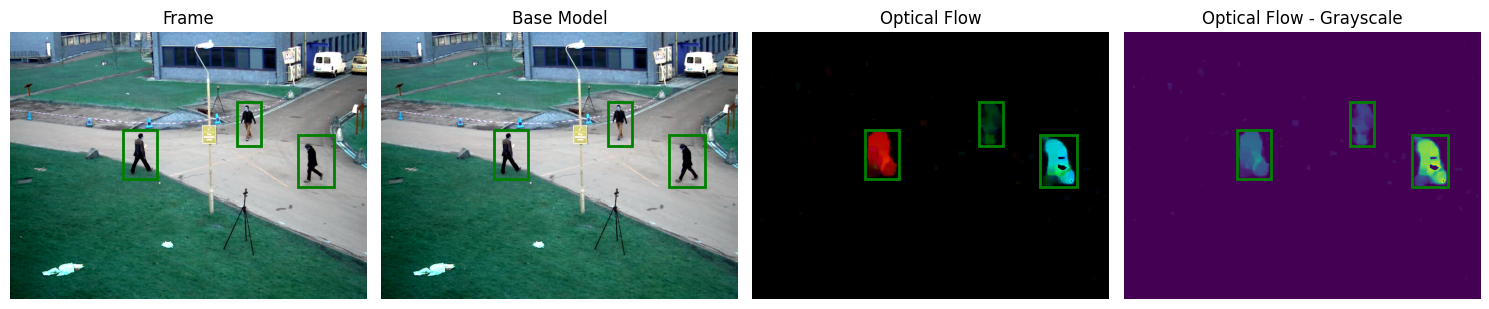

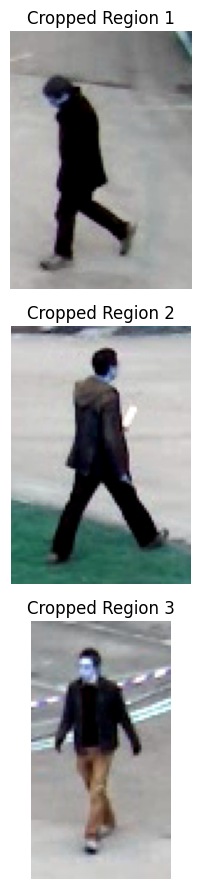

In [5]:


adaptiveThreshold = adaptiveThresh(OpticalFlow_gray,thresh_type=0)
roi_coords = detectROIs(adaptiveThreshold,OpticalFlow_rgb)
cropped_regions = cropROI( roi_coords,image = next_rgb)

if not isMaster:
    plotWithROIs(roi_coords,baseModel_rgb, next_rgb, OpticalFlow_rgb)
    # saveImagesList(cropped_regions,save_path = f'{data_dir}\\ROIs')
    # cropped_regions = loadImagesList(save_path = f'{data_dir}\\ROIs')
    plotCrop(cropped_regions)


#### Object detection - detect inside ROI

load yolo v8

In [6]:

# from app.object_detection.yolo import inferenceYOLOv8Model,plotClassifcation
# from app.object_detection.yolo import loadYOLOv8Model 
# model = loadYOLOv8Model(data_dir)


inference


0: 640x480 1 person, 136.4ms
Speed: 7.0ms preprocess, 136.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 97.9ms
Speed: 2.0ms preprocess, 97.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x352 1 person, 1 car, 116.2ms
Speed: 1.0ms preprocess, 116.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 352)
[{'confidence': array(    0.84987, dtype=float32), 'class': 0, 'name': 'person'}, {'confidence': array(    0.86637, dtype=float32), 'class': 0, 'name': 'person'}, {'confidence': array(    0.91787, dtype=float32), 'class': 0, 'name': 'person'}, {'confidence': array(    0.39075, dtype=float32), 'class': 2, 'name': 'car'}]


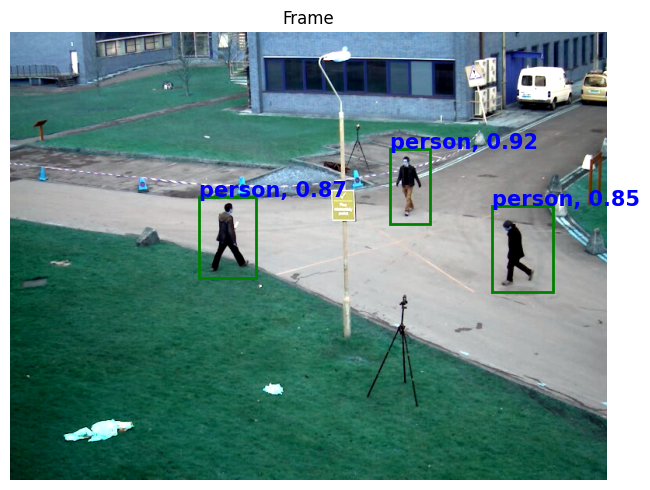

In [7]:
roi_detected = inferenceYOLOv8Model(model,imgs = cropped_regions)
print(roi_detected)
plotClassifcation(roi_coords, next_rgb,roi_detected)

In [8]:
# import cv2
# import numpy as np
# from ultralytics import YOLO

# # Load the pretrained YOLO model
# model = YOLO('yolov5s.pt')  # Using YOLOv5s for this example

# def preprocess_image(img, input_size):
#     """
#     Resize and pad image to match the model's input requirements.
#     """
#     height, width = img.shape[:2]
#     scale = min(input_size[1] / width, input_size[0] / height)
#     new_width = int(width * scale)
#     new_height = int(height * scale)

#     # Resize the image
#     resized = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

#     # Create a blank canvas for padding
#     padded = np.full((input_size[0], input_size[1], 3), 128, dtype=np.uint8)
#     x_offset = (input_size[1] - new_width) // 2
#     y_offset = (input_size[0] - new_height) // 2
#     padded[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized

#     return padded, scale, x_offset, y_offset

# def detect_objects_in_roi(img, roi, model):
#     """
#     Detect objects within a specified ROI using YOLO.
#     """
#     # Crop the ROI
#     x, y, w, h = roi
#     cropped_img = img[y:y+h, x:x+w]

#     # Preprocess the cropped image
#     input_size = (640, 640)  # YOLOv5 default input size
#     preprocessed_img, scale, x_offset, y_offset = preprocess_image(cropped_img, input_size)

#     # Perform detection
#     results = model(preprocessed_img)

#     # Extract results
#     predictions = []
#     for result in results.xyxy[0]:  # xyxy format contains bounding boxes
#         xmin, ymin, xmax, ymax, conf, cls = result[:6]
#         predictions.append({
#             "class": int(cls),
#             "confidence": float(conf),
#             "bbox": [
#                 int((xmin - x_offset) / scale + x),
#                 int((ymin - y_offset) / scale + y),
#                 int((xmax - x_offset) / scale + x),
#                 int((ymax - y_offset) / scale + y),
#             ]
#         })
#     return predictions

# # Example usage:
# # Assume 'img' is a loaded BGR image (e.g., using cv2.imread).
# img = cv2.imread('path_to_image.jpg')

# # Define the ROI (x, y, width, height)
# roi = (100, 50, 300, 300)

# # Detect objects in the ROI
# detections = detect_objects_in_roi(img, roi, model)

# # Print the results
# for det in detections:
#     print(f"Class: {det['class']}, Confidence: {det['confidence']:.2f}, BBox: {det['bbox']}")

# # Optional: Visualize results
# for det in detections:
#     x1, y1, x2, y2 = det['bbox']
#     cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
#     cv2.putText(img, f"{det['class']} ({det['confidence']:.2f})", 
#                 (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# cv2.imshow('Detections', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
